In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import scatter_matrix

In [9]:
csv_files = [file for file in os.listdir('.') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file) for file in csv_files])
df_imported = df_imported.rename(columns={'Unnamed: 0': 'record_time'})
df_imported = df_imported.drop_duplicates(subset='record_time', keep='last')
df_imported = df_imported.set_index('record_time')
print(df_imported.columns)
df_imported

Index(['$', 'dateStamp', 'dew_point', 'modelCode', 'modelRun',
       'periodSchedule', 'pressure', 'screen_relative_humidity',
       'sea_temperature', 'surf_max', 'surf_min', 'swell_direction1',
       'swell_direction2', 'swell_direction3', 'swell_height1',
       'swell_height2', 'swell_height3', 'swell_period1', 'swell_period2',
       'swell_period3', 'temperature', 'wave_height', 'wave_period',
       'wind_direction', 'wind_speed'],
      dtype='object')


,$,dateStamp,dew_point,modelCode,modelRun,periodSchedule,pressure,screen_relative_humidity,sea_temperature,surf_max,...,swell_height2,swell_height3,swell_period1,swell_period2,swell_period3,temperature,wave_height,wave_period,wind_direction,wind_speed
record_time,,,,,,,,,,,,,,,,,,,,,
2016-05-14T16:00:00+00:00,960,NaN,10.7,NaN,NaN,NaN,1023,92.3,12.7,NaN,...,NaN,NaN,NaN,NaN,NaN,11.9,1.1,6,NW,4
2016-05-14T17:00:00+00:00,1020,NaN,10.8,NaN,NaN,NaN,1023,91.6,12.7,NaN,...,NaN,NaN,NaN,NaN,NaN,12.1,1.2,6,NNW,6
2016-05-14T18:00:00+00:00,1080,NaN,10.6,NaN,NaN,NaN,1023,91.7,12.9,NaN,...,NaN,NaN,NaN,NaN,NaN,11.9,1.0,5,NW,5
2016-05-14T19:00:00+00:00,1140,NaN,10.5,NaN,NaN,NaN,1024,91.6,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.8,1.1,5,NW,7
2016-05-14T20:00:00+00:00,1200,NaN,10.3,NaN,NaN,NaN,1024,92.3,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.1,6,WNW,7
2016-05-14T21:00:00+00:00,1260,NaN,10.3,NaN,NaN,NaN,1024,92.3,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.0,6,N,6
2016-05-14T22:00:00+00:00,1320,NaN,10.1,NaN,NaN,NaN,1024,91.6,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.4,1.1,6,WNW,6
2016-05-14T23:00:00+00:00,1380,NaN,9.9,NaN,NaN,NaN,1025,91.0,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.3,1.2,6,NW,7
2016-05-15T00:00:00+00:00,0,NaN,10.1,NaN,NaN,NaN,1025,91.0,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.1,6,WNW,2


In [10]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
# fill NAs with linearly interpolated data
s_target = s_target.interpolate()
print('target values after interpolation:', s_target.count())
s_target

available target values: 9
target values after interpolation: 64


record_time
2016-05-14T16:00:00+00:00         NaN
2016-05-14T17:00:00+00:00         NaN
2016-05-14T18:00:00+00:00         NaN
2016-05-14T19:00:00+00:00         NaN
2016-05-14T20:00:00+00:00         NaN
2016-05-14T21:00:00+00:00         NaN
2016-05-14T22:00:00+00:00         NaN
2016-05-14T23:00:00+00:00         NaN
2016-05-15T00:00:00+00:00         NaN
2016-05-15T01:00:00+00:00    1.000000
2016-05-15T02:00:00+00:00    0.955000
2016-05-15T03:00:00+00:00    0.910000
2016-05-15T04:00:00+00:00    0.865000
2016-05-15T05:00:00+00:00    0.820000
2016-05-15T06:00:00+00:00    0.775000
2016-05-15T07:00:00+00:00    0.730000
2016-05-15T08:00:00+00:00    0.710000
2016-05-15T09:00:00+00:00    0.690000
2016-05-15T10:00:00+00:00    0.670000
2016-05-15T11:00:00+00:00    0.650000
2016-05-15T12:00:00+00:00    0.630000
2016-05-15T13:00:00+00:00    0.610000
2016-05-15T14:00:00+00:00    0.598182
2016-05-15T15:00:00+00:00    0.586364
2016-05-15T16:00:00+00:00    0.574545
2016-05-15T18:00:00+00:00    0.562727


In [11]:
df_explanatory = df_imported[['wind_direction','dew_point', 'screen_relative_humidity', 'pressure', 'wind_speed', 'sea_temperature', 'temperature', 'wave_height', 'wave_period']]
df_explanatory = df_explanatory.dropna()
df_explanatory
print(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('\nbecomes',df_explanatory['wind_direction'].head())

record_time
2016-05-14T16:00:00+00:00     NW
2016-05-14T17:00:00+00:00    NNW
2016-05-14T18:00:00+00:00     NW
2016-05-14T19:00:00+00:00     NW
2016-05-14T20:00:00+00:00    WNW
Name: wind_direction, dtype: object

becomes record_time
2016-05-14T16:00:00+00:00    315.0
2016-05-14T17:00:00+00:00    337.5
2016-05-14T18:00:00+00:00    315.0
2016-05-14T19:00:00+00:00    315.0
2016-05-14T20:00:00+00:00    292.5
Name: wind_direction, dtype: float64


In [12]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
float64,wind_direction
float64,dew_point
float64,screen_relative_humidity
int64,pressure
int64,wind_speed
float64,sea_temperature
float64,temperature
float64,wave_height
float64,wave_period


In [13]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_direction              64
dew_point                   64
screen_relative_humidity    64
pressure                    64
wind_speed                  64
sea_temperature             64
temperature                 64
wave_height                 64
wave_period                 64
surf_avg                    64
dtype: int64

pressure                   -0.969163
screen_relative_humidity   -0.074356
wind_direction             -0.042296
wave_period                -0.004886
dew_point                   0.189713
temperature                 0.321702
sea_temperature             0.519881
wind_speed                  0.728003
wave_height                 0.906388
dtype: float64


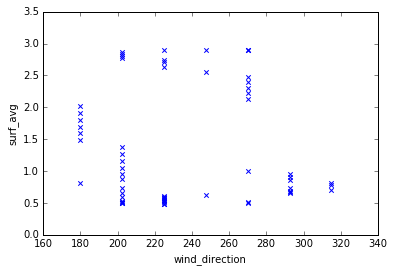

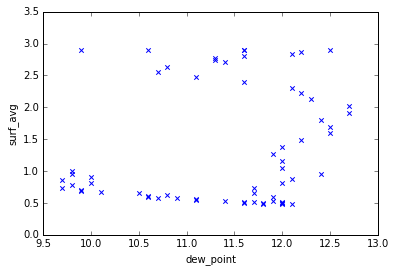

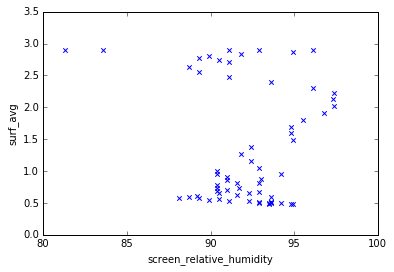

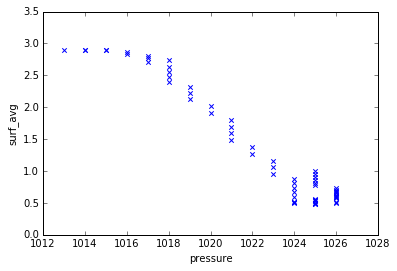

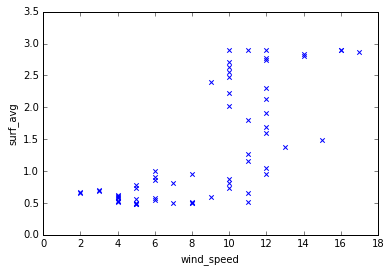

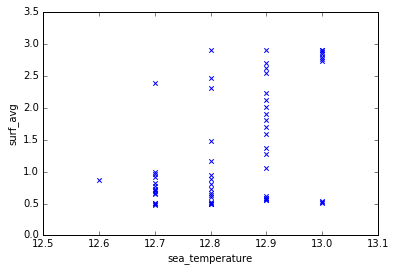

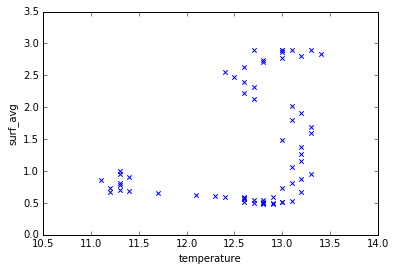

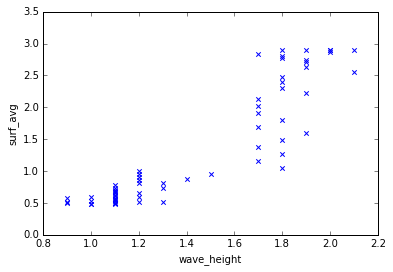

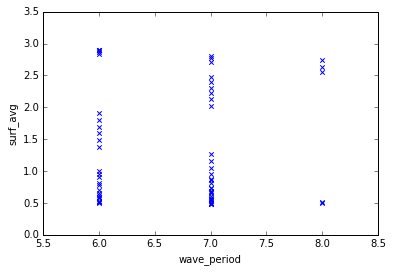

In [16]:
target_correlations = pd.Series([df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns])
target_correlations.index = df_explanatory.columns
print(target_correlations.sort_values())
#fix, axes =plt.subplots(nrows=len(df_explanatory.columns), figsize=(8,8))
for column in df_explanatory.columns:
    df_train.plot.scatter(x=column, y=target_var, marker='x')

In [19]:
df_ewma = pd.ewma(df_explanatory, span=3)
df_ewma

,wind_direction,dew_point,screen_relative_humidity,pressure,wind_speed,sea_temperature,temperature,wave_height,wave_period
record_time,,,,,,,,,
2016-05-14T16:00:00+00:00,315.000000,10.700000,92.300000,1023.000000,4.000000,12.700000,11.900000,1.100000,6.000000
2016-05-14T17:00:00+00:00,330.000000,10.766667,91.833333,1023.000000,5.333333,12.700000,12.033333,1.166667,6.000000
2016-05-14T18:00:00+00:00,321.428571,10.671429,91.757143,1023.000000,5.142857,12.814286,11.957143,1.071429,5.428571
2016-05-14T19:00:00+00:00,318.000000,10.580000,91.673333,1023.533333,6.133333,12.806667,11.873333,1.086667,5.200000
2016-05-14T20:00:00+00:00,304.838710,10.435484,91.996774,1023.774194,6.580645,12.803226,11.680645,1.093548,5.612903
2016-05-14T21:00:00+00:00,150.000000,10.366667,92.150794,1023.888889,6.285714,12.801587,11.588889,1.046032,5.809524
2016-05-14T22:00:00+00:00,221.811024,10.232283,91.873228,1023.944882,6.141732,12.800787,11.493701,1.073228,5.905512
2016-05-14T23:00:00+00:00,268.588235,10.065490,91.434902,1024.474510,6.572549,12.800392,11.396471,1.136863,5.952941
2016-05-15T00:00:00+00:00,280.567515,10.082779,91.217025,1024.737769,4.281800,12.800196,11.448337,1.118395,5.976517
